In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csc_matrix
from sklearn.neighbors import NearestNeighbors
import re
from fuzzywuzzy import process

c:\Users\hadda\.virtualenvs\Machine-learning-Elias-El-Haddad-LBeJrVzk\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
# Load the ratings dataset
ratings = pd.read_csv('../data/ratings.csv')
# Load the movies dataset
movies = pd.read_csv('../data/movies.csv')

## Exploratory Data Analysis

In [3]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264


In [4]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
movies.tail()

,movieId,title,genres
58093,193876,The Great Glinka (1946),(no genres listed)
58094,193878,Les tribulations d'une caissière (2011),Comedy
58095,193880,Her Name Was Mumu (2016),Drama
58096,193882,Flora (2017),Adventure|Drama|Horror|Sci-Fi
58097,193886,Leal (2018),Action|Crime|Drama


In [7]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264


In [8]:
ratings.tail()

,userId,movieId,rating,timestamp
27753439,283228,8542,4.5,1379882795
27753440,283228,8712,4.5,1379882751
27753441,283228,34405,4.5,1379882889
27753442,283228,44761,4.5,1354159524
27753443,283228,54286,4.5,1354159718


In [9]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27753444 entries, 0 to 27753443
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 847.0 MB


In [10]:
movies.info() # No missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58098 entries, 0 to 58097
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  58098 non-null  int64 
 1   title    58098 non-null  object
 2   genres   58098 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.3+ MB


In [11]:
# check for missing values in ratings
ratings.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [12]:
# number of unique titles in the movies dataset
movies['title'].nunique()

58020

In [13]:
# number of movieid in ratings
ratings['movieId'].nunique()

53889

In [14]:
# number of movieid in movies
movies['movieId'].nunique()

58098

We notice that:
- the number of movieId in movies df is greater than the number of movieId in ratings df.
- the number of titles is less than the number of movieId in movies df.

I will investigate this issue once we get to data cleaning, maybe it would be a way to filter out data. 

In [15]:
# number of unique userid in ratings
ratings['userId'].nunique()

283228

In [16]:
# convert timestamp to datetime
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')
ratings.head()

,userId,movieId,rating,timestamp
0,1,307,3.5,2009-10-27 21:00:21
1,1,481,3.5,2009-10-27 21:04:16
2,1,1091,1.5,2009-10-27 21:04:31
3,1,1257,4.5,2009-10-27 21:04:20
4,1,1449,4.5,2009-10-27 21:01:04


In [17]:
# what's the oldest and newset movie in the dataset
ratings['timestamp'].min(), ratings['timestamp'].max()

(Timestamp('1995-01-09 11:46:44'), Timestamp('2018-09-26 06:59:09'))

## Top 10 movies with most ratings:

In [18]:
# Top 10 movies with the highest number of ratings
top10_movies = ratings.groupby('movieId')['rating'].count().sort_values(ascending=False).head(10)

# The map function is used to get the movie titles corresponding to the top 10 movieIds with the highest number of ratings.
highest_ratings = top10_movies.index.map(movies.set_index('movieId')['title'])

for movie in highest_ratings:
    print(movie)

Shawshank Redemption, The (1994)
Forrest Gump (1994)
Pulp Fiction (1994)
Silence of the Lambs, The (1991)
Matrix, The (1999)
Star Wars: Episode IV - A New Hope (1977)
Jurassic Park (1993)
Schindler's List (1993)
Braveheart (1995)
Toy Story (1995)


## Calculate the average rating for these 10 movies with the most ratings:

In [19]:
# Top 10 movies with the highest number of ratings
top10_movies = ratings.groupby('movieId')['rating'].count().sort_values(ascending=False).head(10)

# Calculate the average rating for each movie
average_ratings = ratings.groupby('movieId')['rating'].mean()

# Get the average ratings for the top 10 movies with the most ratings
top10_movies_avg_ratings = average_ratings.loc[top10_movies.index]

# Print the top 10 movies with their titles and average ratings
for title, avg_rating in zip(highest_ratings, top10_movies_avg_ratings):
    print(f'{title}, Average Rating: {avg_rating:.2f}')

Shawshank Redemption, The (1994), Average Rating: 4.42
Forrest Gump (1994), Average Rating: 4.06
Pulp Fiction (1994), Average Rating: 4.17
Silence of the Lambs, The (1991), Average Rating: 4.15
Matrix, The (1999), Average Rating: 4.15
Star Wars: Episode IV - A New Hope (1977), Average Rating: 4.12
Jurassic Park (1993), Average Rating: 3.67
Schindler's List (1993), Average Rating: 4.26
Braveheart (1995), Average Rating: 4.01
Toy Story (1995), Average Rating: 3.89


## A plot of years and the number of movies represented in the dataset:

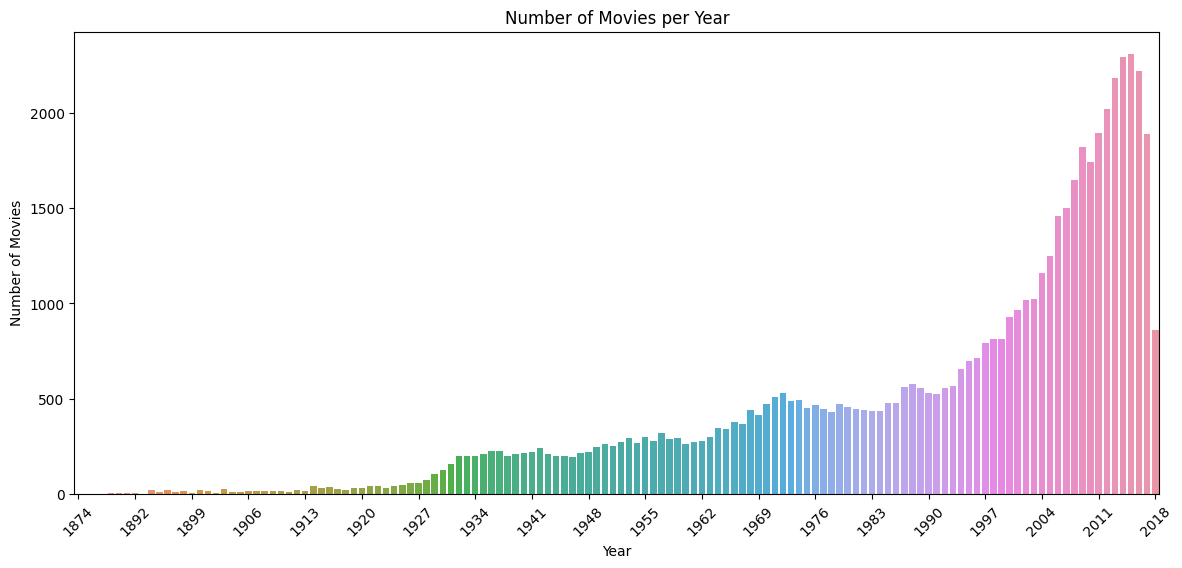

In [20]:
# Extract the release years from the movie titles
movies['year'] = movies['title'].str.extract(r'\((\d{4})\)')

# Count the number of movies for each year
year_counts = movies['year'].value_counts().sort_index()

# Get the index of the years in order to plot them
year_index = year_counts.index

# Plot the number of movies per year
plt.figure(figsize=(14, 6))
sns.barplot(x=year_index, y=year_counts) 
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.title('Number of Movies per Year')

# Adjust the x-axis ticks to display fewer years so they don't overlap
xticks = np.arange(0, len(year_counts), 7) # this creates some sort of template for the xticks (0 to the length of the year_counts, with a step of 7)
plt.xticks(ticks=xticks, labels=year_index[xticks], rotation=45)
plt.show()

## A plot of the number of ratings against the movieId:

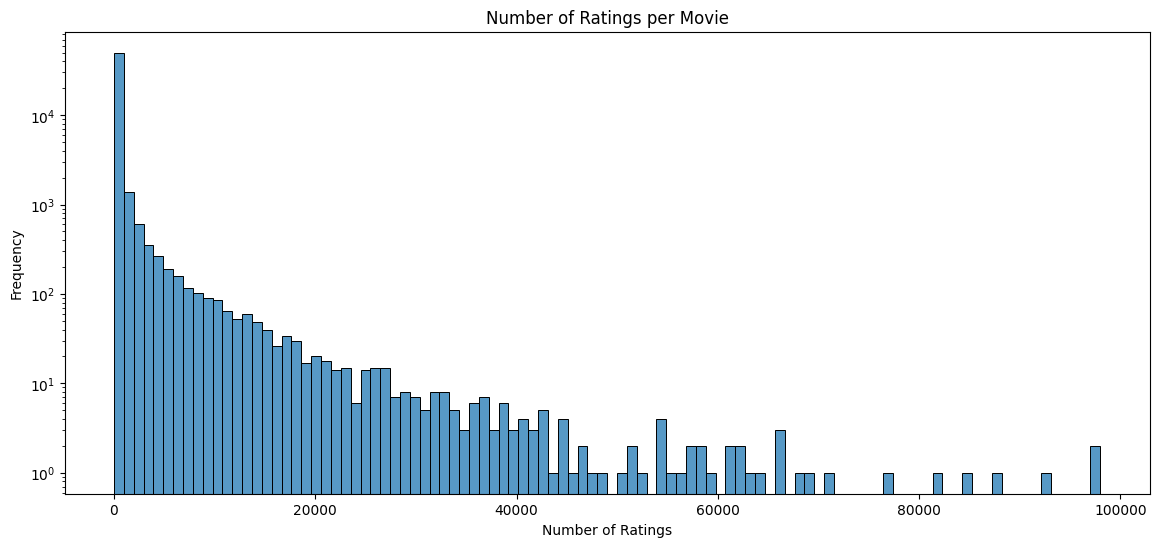

In [21]:
# Count the number of ratings for each movieId
rating_counts = ratings.groupby('movieId')['rating'].count()

# Create a histogram of the number of ratings per movie using Seaborn
plt.figure(figsize=(14, 6))
sns.histplot(rating_counts, bins=100, log_scale=(False, True)) # log_scale=(False, True) means that the x-axis is not log-scaled, but the y-axis is
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')
plt.title('Number of Ratings per Movie')
plt.show()

## A plot of the top 10 movies with the highest average rating:

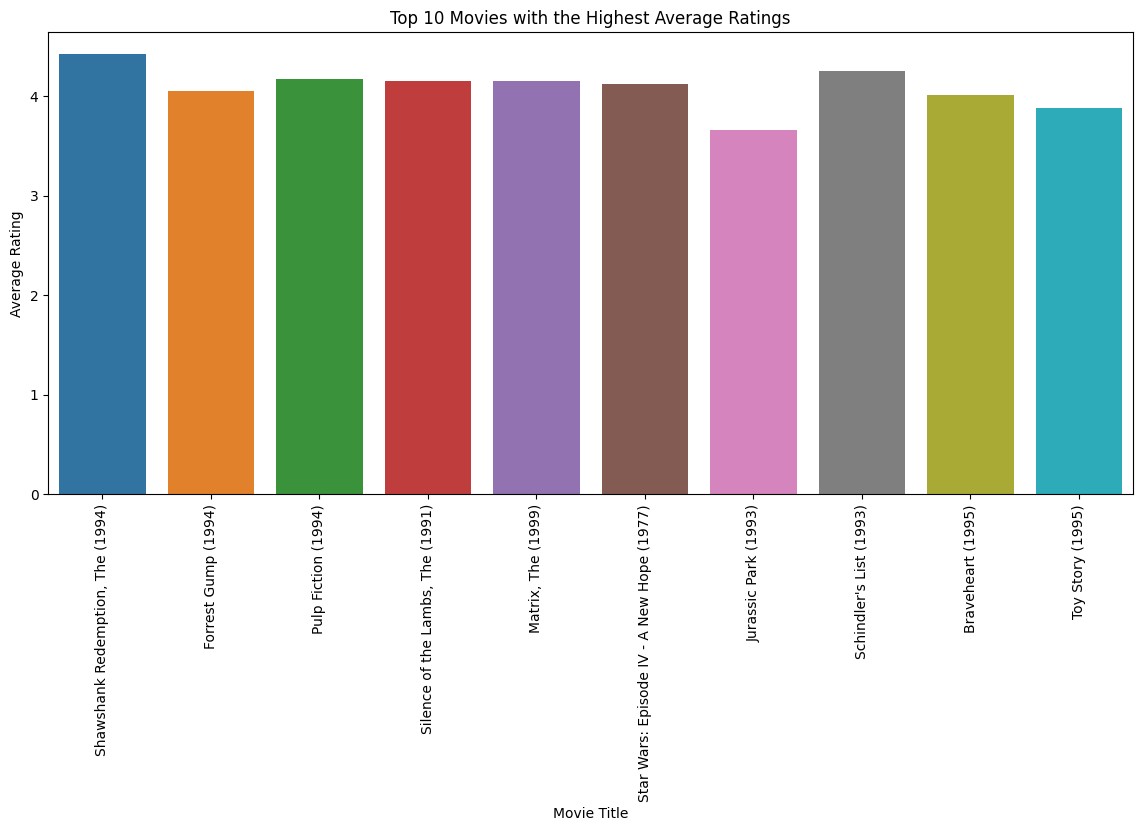

In [22]:
plt.figure(figsize=(14, 6))
sns.barplot(x=highest_ratings, y=top10_movies_avg_ratings)
plt.xlabel('Movie Title')
plt.ylabel('Average Rating')
plt.title('Top 10 Movies with the Highest Average Ratings')
plt.xticks(rotation=90)
plt.show()

## Data cleaning

Since we have to clean our data so that the sparse matrix is not too big, we will have to filter out some data. For that I thought i will start by removing:
- movies with less than 200 ratings
- duplicated titles
- movies with less than 2 average rating
    - To filter out at average rating of 2 felt a little bit too extreme for me. But for the sake of completing this project on time, I had to go this way because that was the only value that worked with my sparse matrix, otherwise VSCode kept crashing or I would get a memory error, both of which I couldn't fix.
- movies with missing movieIds
- movies with no genres listed
- movies older than 1970

In [23]:
# remove timestamp column
ratings.drop('timestamp', axis=1, inplace=True)
ratings.head()

,userId,movieId,rating
0,1,307,3.5
1,1,481,3.5
2,1,1091,1.5
3,1,1257,4.5
4,1,1449,4.5


In [24]:
# movies with less than 200 ratings

movies_less_than_200_ratings = rating_counts[rating_counts < 200].index
movies_less_than_200_ratings

Int64Index([    33,     37,     51,     53,     56,     67,     84,     98,
               106,    108,
            ...
            193866, 193868, 193870, 193872, 193874, 193876, 193878, 193880,
            193882, 193886],
           dtype='int64', name='movieId', length=45717)

In [25]:
# check for duplicate titles

# group the movies by title and count the number of movieids for each title
duplicate_titles = movies.groupby('title')['movieId'].count()

# get the titles that have more than one movieid
duplicate_titles = duplicate_titles[duplicate_titles > 1]
duplicate_titles.head()

title
20,000 Leagues Under the Sea (1997)    2
Absolution (2015)                      2
Aftermath (2012)                       2
Aladdin (1992)                         2
Another World (2014)                   2
Name: movieId, dtype: int64

In [26]:
# check the missing movieids

missing_movieIds = movies[~movies['movieId'].isin(ratings['movieId'])] # ~ means not
missing_movieIds.head()

,movieId,title,genres,year
8403,25817,Break of Hearts (1935),Drama|Romance,1935
8800,26361,Baby Blue Marine (1976),Drama,1976
9221,27153,Can't Be Heaven (Forever Together) (2000),Children|Comedy|Drama|Romance,2000
9336,27433,Bark! (2002),Comedy|Drama,2002
9809,31945,Always a Bridesmaid (2000),Documentary,2000


In [27]:
# check movie with ratings less or equal to 2

# Group ratings DataFrame by movieid and calculate the mean rating for each movie
mean_ratings = ratings.groupby("movieId")["rating"].mean()

# Filter movieids with an average rating of 2 or less
low_rated_movies_ids = mean_ratings[mean_ratings <= 2].index

# Get the complete information for these movies from the movie dataframe
low_rated_movies = movies[movies["movieId"].isin(low_rated_movies_ids)]
low_rated_movies.head()

,movieId,title,genres,year
179,181,Mighty Morphin Power Rangers: The Movie (1995),Action|Children,1995
389,393,Street Fighter (1994),Action|Adventure|Fantasy,1994
635,642,Roula (1995),Drama,1995
727,739,Honey Moon (Honigmond) (1996),Comedy,1996
797,810,Kazaam (1996),Children|Comedy|Fantasy,1996


In [28]:
# check for movies with no genre

movies_with_no_genre = movies[movies['genres'] == '(no genres listed)']
movies_with_no_genre.head()

,movieId,title,genres,year
16662,83773,Away with Words (San tiao ren) (1999),(no genres listed),1999
16677,83829,Scorpio Rising (1964),(no genres listed),1964
16856,84768,Glitterbug (1994),(no genres listed),1994
17178,86493,"Age of the Earth, The (A Idade da Terra) (1980)",(no genres listed),1980
17343,87061,Trails (Veredas) (1978),(no genres listed),1978


In [29]:
# Extract the year from the title using a regular expression
movies['year'] = movies['title'].str.extract(r'\((\d{4})\)').astype(float) 

# Filter the movies DataFrame to get movies released before 1970
movies_older_than_1970 = movies[movies['year'] < 1970]
movies_older_than_1970.head()

,movieId,title,genres,year
152,154,Beauty of the Day (Belle de jour) (1967),Drama,1967.0
197,199,"Umbrellas of Cherbourg, The (Parapluies de Che...",Drama|Musical|Romance,1964.0
386,390,Faster Pussycat! Kill! Kill! (1965),Action|Crime|Drama,1965.0
588,594,Snow White and the Seven Dwarfs (1937),Animation|Children|Drama|Fantasy|Musical,1937.0
590,596,Pinocchio (1940),Animation|Children|Fantasy|Musical,1940.0


In [30]:
# filter out movies with less than 200 ratings
filtered_ratings = ratings[~ratings['movieId'].isin(movies_less_than_200_ratings)]

# filter out duplicate titles

# Get the first movieId for each duplicate title
unique_movieIds = movies.groupby('title')['movieId'].first() # first() returns the first value in the group

# Filter out the duplicates from the filtered_ratings DataFrame
filtered_ratings = filtered_ratings[filtered_ratings['movieId'].isin(unique_movieIds.values)]

# filter out movies with missing movieIds
filtered_ratings = filtered_ratings[~filtered_ratings['movieId'].isin(missing_movieIds['movieId'])]

# filter out low rated movies
filtered_ratings = filtered_ratings[~filtered_ratings['movieId'].isin(low_rated_movies_ids)]

# filter out movies with no genre
filtered_ratings = filtered_ratings[~filtered_ratings['movieId'].isin(movies_with_no_genre['movieId'])]

# filter out movies older than 1970
filtered_ratings = filtered_ratings[~filtered_ratings['movieId'].isin(movies_older_than_1970['movieId'])]

In [31]:
filtered_ratings.shape, ratings.shape

((24933299, 3), (27753444, 3))

## Create a sparse matrix of the ratings:

In [32]:
movies_users = filtered_ratings.pivot(index='movieId', columns='userId', values='rating').fillna(0)
movies_users.head()

userId,1,2,3,4,5,6,7,8,9,10,...,283219,283220,283221,283222,283223,283224,283225,283226,283227,283228
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,5.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.5
2,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,2.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
mat_movies_users = csc_matrix(movies_users.values) # convert movies_users to a sparse matrix
mat_movies_users

<7167x282639 sparse matrix of type '<class 'numpy.float64'>'
	with 24933299 stored elements in Compressed Sparse Column format>

In [34]:
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20) # create a KNN model

In [35]:
model_knn.fit(mat_movies_users) # fit the model to the sparse matrix

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=20)

In [36]:
def recommend_movies(movie_name, data, model, n_recommendations):
    
    model.fit(data)
    idx = process.extractOne(movie_name, movies['title'])[2]
    print('Movie Selected: ', movies['title'][idx], ' Index: ',idx)
    print('Searching for recommendations......')
    distances, indices = model.kneighbors(data[idx], n_neighbors=n_recommendations + 1) # +1 because the first movie is the movie itself
    for i in indices:
        print(movies['title'][i].where(i != idx))

recommend_movies('superman', mat_movies_users, model_knn, 20)

Movie Selected:  Superman (1978)  Index:  2556
Searching for recommendations......
2556                                                  NaN
4123                            Longtime Companion (1990)
2472                                   Telling You (1998)
2283                                     King Kong (1976)
2024    Halloween H20: 20 Years Later (Halloween 7: Th...
3085                               Room at the Top (1959)
2185                             Indecent Proposal (1993)
2122                              Mr. & Mrs. Smith (1941)
3037    Lauderdale (a.k.a. Spring Break USA) (a.k.a. S...
2360                       24 7: Twenty Four Seven (1997)
2555                                Mommie Dearest (1981)
3094                           Play it to the Bone (1999)
1657                                      Scream 2 (1997)
2815                                 Monkey Shines (1988)
2111                             Untouchables, The (1987)
3053                           Tarzan the Fearl

## Explain how the system works
1. The dataset is first loaded and preprocessed, which includes filtering out movies based on certain criteria such as the number of ratings, duplicate titles, missing movieIds, genre, and release year.
2. The ratings dataset is transformed into a sparse matrix, with movieIds as rows and userIds as columns, and each cell representing a rating given by a user to a movie. If a user hasn't rated a movie, the cell is filled with 0.
3. A KNN model is trained on this sparse matrix. This model can find 'k' nearest neighbors (in this case, 20) for a given data point.
4. The recommendation function takes a movie name, data (sparse matrix), KNN model, and the number of recommendations as input. It searches for the most similar movie title in the dataset using fuzzywuzzy.
5. The function then returns the titles of these similar movies as recommendations, excluding the selected movie itself.

## How recommender system works in general
A recommender system is a machine learning technique used to predict and provide personalized recommendations for products, content, or services. It is widely used by major companies like Google, Amazon, Netflix, and Spotify. Recommender systems can be categorized into three main types: collaborative filtering, content-based, and hybrid systems.

- Collaborative filtering does its prediction by analyzing patterns and similarities among multiple users. It can be divided into memory-based and model-based approaches.

- Content-based systems generate recommendations based on the user's previous choices. This method requires a strong source of item-level and user-level data, and it works well when there is limited rating data available. However, it can sometimes result in less diverse recommendations.

- Hybrid recommendation systems combine the advantages of both collaborative filtering and content-based approaches to provide more robust and personalized recommendations. The main drawback of hybrid systems is their high computational complexity and the need for a large and up-to-date database.

In summary, recommender systems play a crucial role in providing personalized recommendations to users by analyzing user preferences, item attributes, and uses different techniques to optimize the recommendation quality.

source: https://towardsdatascience.com/recommendation-systems-explained-a42fc60591ed